# Analysis_Waterloo-Part4

We will apply machine learning.

In [84]:
import scipy.io

import pandas as pd
import numpy as np
import statistics

import math
import seaborn as sns

import statistics

import re 
from scipy.stats import spearmanr

from platform import python_version
print(python_version())

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

from itertools import combinations_with_replacement, combinations

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter

from scipy.stats.stats import pearsonr, kendalltau, spearmanr

3.7.4


In [85]:
data_all = pd.read_pickle("Part3_tmp")

In [86]:
categorical_subset = data_all[['content', 'motion', "Constant_bitrate"]]
mos = data_all["MOS"]
numerical_subset = data_all.copy()
numerical_subset = numerical_subset.drop (["MOS", 'content', 'motion', "Constant_bitrate"], axis = 1)

In [87]:
len (numerical_subset.columns) + len (categorical_subset.columns) 

27

Next we  change names of the categories to numbers

In [88]:
categorical_subset = pd.get_dummies(categorical_subset)

In [89]:
#categorical_subset

In [90]:
features = pd.concat([numerical_subset, categorical_subset], axis = 1)
targets = mos

## Stratification
It is common practise in classification tasks.
But very uncommon in regression

Here you can fing a great papar [about it](https://scottclowe.com/2016-03-19-stratified-regression-partitions/) 

In [91]:
columns_save = features.columns

In [92]:
import random
index_test =[]
index_val= []
for i in range(45):
    #random.seed(42) 
    a = random.randint(10*i, 9 + 10*i)
    index_test.append (a)
    #random.seed(24) 
    while (a != 0):
        b = random.randint(10*i, 9 + 10*i)
        if (a!=b):
            a = 0
            index_val.append (b)

In [93]:
print (index_test)
print(index_val)
len(index_val)

[7, 16, 25, 35, 47, 51, 64, 70, 89, 98, 101, 113, 122, 138, 149, 150, 167, 177, 189, 197, 200, 214, 228, 234, 244, 258, 262, 273, 283, 293, 300, 319, 321, 332, 346, 355, 361, 371, 387, 393, 401, 414, 420, 430, 447]
[3, 11, 27, 39, 43, 59, 66, 78, 80, 91, 102, 115, 121, 133, 141, 156, 166, 171, 181, 190, 207, 216, 226, 238, 245, 259, 267, 272, 288, 291, 303, 311, 328, 338, 347, 359, 364, 378, 382, 395, 408, 419, 427, 436, 449]


45

In [94]:
k=10 #Number of folds
n = 45#450/k
k_folds = np.zeros((k,n))
#Sorted by MOS
sorted_features = pd.concat([features, targets], axis = 1)
sorted_features = sorted_features.sort_values(['MOS'])
sorted_features.set_index(np.arange(450) )

val = sorted_features.iloc [index_val]

targets = pd.DataFrame(sorted_features["MOS"])
sorted_features = sorted_features.drop (["MOS"], axis = 1)

X = sorted_features.drop(index_test)
X = X.drop(index_val)
X_test = sorted_features.iloc [index_test]
X_val = sorted_features.iloc [index_val]

train_labels = targets.drop(index_test)
train_labels = train_labels.drop(index_val)
test_labels = targets.iloc [index_test]
val_labels = targets.iloc [index_val]

In [95]:
print(X.shape)
print(X_test.shape)
print(X_val.shape)
print(train_labels.shape)
print(test_labels.shape)
print(val_labels.shape)

(360, 27)
(45, 27)
(45, 27)
(360, 1)
(45, 1)
(45, 1)


In [96]:
X_with_cols = pd.DataFrame(X, columns = columns_save)

## Models to Evaluate

We will compare five different machine learning models using the great [Scikit-Learn library](http://scikit-learn.org/stable/):

1. Linear Regression
2. Support Vector Machine Regression
3. Random Forest Regression
4. Gradient Boosting Regression
5. K-Nearest Neighbors Regression

Again, here I'm focusing on implementation rather than explaining how these work. In addition to Hands-On Machine Learning, another great resource (this one is free online) for reading about machine learning models is [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/).

To compare the models, we are going to be mostly using the Scikit-Learn defaults for the model hyperparameters. Generally these will perform decently, but should be optimized before actually using a model. At first, we just want to determine the baseline performance of each model, and then we can select the best performing model for further optimization using hyperparameter tuning. Remember that the default hyperparameters will get a model up and running, but nearly always should be adjusted using some sort of search to find the best settings for your problem! 

Here is what the Scikit-learn documentation [says about the defaults](https://arxiv.org/abs/1309.0238):

    __Sensible defaults__: Whenever an operation requires a user-defined parameter,
    an appropriate default value is defined by the library. The default value
    should cause the operation to be performed in a sensible way (giving a baseline
    solution for the task at hand.)

One of the best parts about scikit-learn is that all models are implemented in an identical manner: once you know how to build one, you can implement an extremely diverse array of models. Here we will implement the entire training and testing procedures for a number of models in just a few lines of code.

In [97]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [98]:
baseline_guess = np.median(train_labels)

print('The baseline guess is a score of %0.2f' % baseline_guess)
print("Baseline Performance on the test set: MAE = %0.4f" % mae(test_labels, baseline_guess))

The baseline guess is a score of 62.10
Baseline Performance on the test set: MAE = 11.8228


In [99]:
# Imputing missing values and scaling values
from sklearn.preprocessing import MinMaxScaler

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

## Scaling Features

In [100]:
# Convert y to one-dimensional array (vector)
y = np.array(train_labels).reshape((-1, ))
y_test = np.array(test_labels).reshape((-1, ))
y_val = np.array(val_labels).reshape((-1, ))

In [101]:
# Function to calculate mean absolute error
#def mae(y_true, y_pred):
    #return np.mean(abs(y_true - y_pred))
    
def mae(y_true, y_val, y_pred, y_pred_val):    
    return np.mean(abs(y_true - y_pred)), np.mean(abs(y_val - y_pred_val))

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X, y)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    
    y_pred_val = model.predict(X_val)
    #model_mae = mae(y_test, model_pred)
    model_mae = mae(y_test, y_val, model_pred, y_pred_val)
    
    corr_test = spearmanr(test_labels, model_pred)
    corr_val = spearmanr(y_val, y_pred_val)
    
    print ("SRCC test", round(corr_test[0],4), corr_test[1])
    print ("SRCC validation", round(corr_val[0],4), corr_val[1])
    
    # Return the performance metric
    return model_mae, corr_val[0]

In [102]:
lr = LinearRegression()
lr_mae, corr_lr = fit_and_evaluate(lr)

print('Linear Regression Performance: MAE test = %0.4f, MAE val = %0.4f' % lr_mae)

SRCC test 0.9029 2.2786059841421144e-17
SRCC validation 0.8755 3.598377502826408e-15
Linear Regression Performance: MAE test = 5.0785, MAE val = 5.3269


In [103]:
svm = SVR(C = 1000, gamma = 0.1)
svm_mae, corr_svm = fit_and_evaluate(svm)

print('Support Vector Machine Regression Performance: MAE test = %0.4f, MAE val = %0.4f' % svm_mae)

SRCC test 0.9192 5.148795115469475e-19
SRCC validation 0.9118 3.1372781797053525e-18
Support Vector Machine Regression Performance: MAE test = 1.7326, MAE val = 2.5042


In [104]:
random_forest = RandomForestRegressor(random_state=42)
random_forest_mae, corr_random_forest = fit_and_evaluate(random_forest)

print('Random Forest Regression Performance: MAE test = %0.4f, MAE val = %0.4f' % random_forest_mae)

SRCC test 0.98 8.988461565889573e-32
SRCC validation 0.9819 9.817954208018139e-33
Random Forest Regression Performance: MAE test = 2.3253, MAE val = 2.0165


In [105]:
gradient_boosted = GradientBoostingRegressor(random_state=42)
gradient_boosted_mae, corr_gradient_boosted = fit_and_evaluate(gradient_boosted)
print('Gradient Boosted Regression Performance: MAE test = %0.4f, MAE val = %0.4f' % gradient_boosted_mae)

SRCC test 0.9726 7.090557578751438e-29
SRCC validation 0.9783 5.1593727777056e-31
Gradient Boosted Regression Performance: MAE test = 2.5623, MAE val = 2.2214


In [106]:
knn = KNeighborsRegressor(n_neighbors=10)
knn_mae, corr_knn = fit_and_evaluate(knn)

print('K-Nearest Neighbors Regression Performance: MAE test = %0.4f, MAE val = %0.4f' % knn_mae)

SRCC test 0.7523 2.5449042642289407e-09
SRCC validation 0.8248 3.275702268693151e-12
K-Nearest Neighbors Regression Performance: MAE test = 7.4090, MAE val = 6.9346


## MOS values updating 

There are a hypothesis that QoE function has a sigmoid nature, like this:

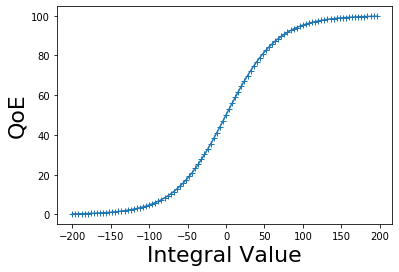

In [107]:
#Sigmoid hypothesis
x = np.arange(-200, 200, 4).tolist()
y = []

b1 = 100 #Scaling factor, constant
b2 = -0.03 #КSlope factor, also can be included in the weights in integral value V
b3 = 200 #Offset along the Ox axis, entered into X itself. 
#x = summ (w.i * xi) - there is some kind of polynomial. b3 - the constant term
#sigma = b1/(b2 + b3*exp(-x))
def sigma(x):
    sigma = 100/(1 + math.exp(b2*(x)))
   
    return sigma

y= list (map(lambda x : sigma(x), x))

fig, ax = plt.subplots()
ax.plot(x, y, '+', linestyle='solid')

plt.xlabel('Integral Value', size = 22);
plt.ylabel('QoE', size = 22);


## But we will see next that it can also be like this: 

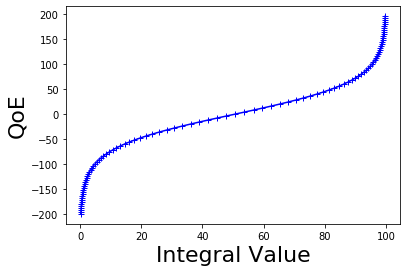

In [108]:
##Logarithmic hypothesis
x = np.arange(-200, 200, 4).tolist()
y = []

b1 = 100 
b2 = -0.03 
b3 = 1 
def sigma(x):
    sigma = -b1/(1 + math.exp(b2*(-x-b3))) + 100
   
    return sigma

y = list (map(lambda x : sigma(x), x))

fig, ax = plt.subplots()
ax.plot(y, x, 'b+', linestyle='solid')
plt.xlabel('Integral Value', size = 22);
plt.ylabel('QoE', size = 22);
plt.show()

In [109]:
features = pd.concat([numerical_subset, categorical_subset], axis = 1)
targets = mos

In [110]:
def transmutation(mos):
    return math.log(mos/(100-mos))

#I also have some ideas that QoE has a logarifmic nature
def transmutation2(mos):
    #return 1/(1+math.exp((12/100)*(50-mos)))
    return 1/(1+math.exp((0.08)*(50-mos)))
    #return 100/(1+math.exp((0.1)*(40-mos)))

#for index, row in targets.iterrows():
for i in range(len(targets)):
    
    #value = transmutation(row['MOS'])
    #print (value)
    #targets.at[index, 'MOS'] = value
    
    value = transmutation(targets[i])
    targets[i] = value

/home/ksant/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [111]:
k=10
n = 45#450/k
k_folds = np.zeros((k,n))

sorted_features = pd.concat([features, targets], axis = 1)
sorted_features = sorted_features.sort_values(['MOS'])
sorted_features.set_index(np.arange(450) )

val = sorted_features.iloc [index_val]

targets = pd.DataFrame(sorted_features["MOS"])
sorted_features = sorted_features.drop (["MOS"], axis = 1)

X = sorted_features.drop(index_test)
X = X.drop(index_val)
X_test = sorted_features.iloc [index_test]
X_val = sorted_features.iloc [index_val]

train_labels = targets.drop(index_test)
train_labels = train_labels.drop(index_val)
test_labels = targets.iloc [index_test]
val_labels = targets.iloc [index_val]

In [112]:
X_with_cols = pd.DataFrame(X, columns = columns_save)

## Scaling Features

In [113]:
# Convert y to one-dimensional array (vector)
y = np.array(train_labels).reshape((-1, ))
y_test = np.array(test_labels).reshape((-1, ))
y_val = np.array(val_labels).reshape((-1, ))

In [114]:
lr = LinearRegression()
lr_maea, corr_lr_t = fit_and_evaluate(lr)

print('Linear Regression Performance: MAE test = %0.4f, MAE val = %0.4f' % lr_maea)

SRCC test 0.91 4.772880832282777e-18
SRCC validation 0.8725 5.847430693163335e-15
Linear Regression Performance: MAE test = 0.2398, MAE val = 0.2633


In [115]:
svm = SVR(C = 1000, gamma = 0.1)
svm_maea, corr_svm_t = fit_and_evaluate(svm)

print('Support Vector Machine Regression Performance: MAE test = %0.4f, MAE val = %0.4f' % svm_maea)

SRCC test 0.9218 2.606424771640244e-19
SRCC validation 0.9152 1.3973301313444452e-18
Support Vector Machine Regression Performance: MAE test = 0.1696, MAE val = 0.1812


In [116]:
random_forest = RandomForestRegressor(random_state=42)
random_forest_maea, corr_random_forest_t = fit_and_evaluate(random_forest)

print('Random Forest Regression Performance: MAE test = %0.4f, MAE val = %0.4f' % random_forest_maea)

SRCC test 0.9725 7.850480720416759e-29
SRCC validation 0.9833 1.949657052036717e-33
Random Forest Regression Performance: MAE test = 0.1165, MAE val = 0.0985


In [117]:
gradient_boosted = GradientBoostingRegressor(random_state=42)
gradient_boosted_maea, corr_gradient_boosted_t = fit_and_evaluate(gradient_boosted)
print('Gradient Boosted Regression Performance: MAE test = %0.4f, MAE val = %0.4f' % gradient_boosted_maea)

SRCC test 0.9738 2.771829704289645e-29
SRCC validation 0.9809 3.2916893609309045e-32
Gradient Boosted Regression Performance: MAE test = 0.1293, MAE val = 0.1043


In [118]:
knn = KNeighborsRegressor(n_neighbors=10)
knn_maea, corr_knn_t = fit_and_evaluate(knn)

print('K-Nearest Neighbors Regression Performance: MAE test = %0.4f, MAE val = %0.4f' % knn_maea)

SRCC test 0.7473 3.7030466419161365e-09
SRCC validation 0.8235 3.783176216585284e-12
K-Nearest Neighbors Regression Performance: MAE test = 0.3542, MAE val = 0.3451


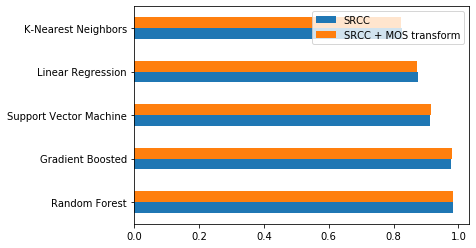

In [119]:
corr = [corr_lr, corr_svm, corr_random_forest, 
                                         corr_gradient_boosted, corr_knn]

corr_t = [corr_lr_t, corr_svm_t, corr_random_forest_t, 
                                         corr_gradient_boosted_t, corr_knn_t]

index = ['Linear Regression', 'Support Vector Machine',
                                           'Random Forest', 'Gradient Boosted',
                                            'K-Nearest Neighbors']
df = pd.DataFrame({'SRCC': corr, 'SRCC + MOS transform': corr_t}, index=index)
df=df.sort_values('SRCC + MOS transform', ascending = False)
ax = df.plot.barh()

### MOS transmutation
So, we have some increase in terms of MAE and also we have some simplification of models in terms of a number of estimators

## Model Optimization 

In machine learning, optimizing a model means finding the best set of hyperparameters for a particular problem. 

## Hyperparameters

First off, we need to understand what [model hyperparameters are in contrast to model parameters](https://machinelearningmastery.com/difference-between-a-parameter-and-a-hyperparameter/) :

* Model __hyperparameters__ are best thought of as settings for a machine learning algorithm that are tuned by the data scientist before training. Examples would be the number of trees in the random forest, or the number of neighbors used in K Nearest Neighbors Regression. 
* Model __parameters__ are what the model learns during training, such as the weights in the linear regression.

We as data scientists control a model by choosing the hyperparameters, and these choices can have a significant effect on the final performance of the model (although usually not as great of an effect as getting more data or engineering features). 

[Tuning the model hyperparameters](http://scikit-learn.org/stable/modules/grid_search.html) controls the balance of under vs over fitting in a model. We can try to correct for under-fitting by making a more complex model, such as using more trees in a random forest or more layers in a deep neural network. A model that underfits has high bias, and occurs when our model does not have enough capacity (degrees of freedom) to learn the relationship between the features and the target. We can try to correct for overfitting by limiting the complexity of the model and applying regularization. This might mean decreasing the degree of a polynomial regression, or adding dropout layers to a deep neural network. A model that overfits has high variance and in effect has memorized the training set. Both underfitting and overfitting lead to poor generalization performance on the test set. 

The problem with choosing the hyperparameters is that no set will work best across all problems. Therefore, for every new dataset, we have to find the best settings. This can be a time-consuming process, but luckily there are several options for performing this procedure in Scikit-Learn. Even better, new libraries, such as [TPOT](https://epistasislab.github.io/tpot/) by epistasis labs, is aiming to do this process automatically for you! For now, we will stick to doing this manually (sort of) in Scikit-Learn, but stay tuned for an article on automatic model selection! 

In [37]:
# Loss function to be optimized
loss = ['ls', 'lad', 'huber']

# Number of trees used in the boosting process
n_estimators = [80, 85, 90, 95, 100, 110, 120, 130, 140, 150, 160,
                170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 
                280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410]

# Maximum depth of each tree
max_depth = [3, 4, 5, 6, 7]

# Minimum number of samples per leaf
min_samples_leaf = [3, 4, 5, 6]

# Minimum number of samples to split a node
min_samples_split = [8, 9, 10, 11, 12, 13, 14]

# Maximum number of features to consider for making splits
max_features = ['auto', 'sqrt', 'log2', None]

#Регяляризация
penalty=['l2', 'l1']

#Параметр регуляризации
alpha = np.linspace(0.0001, 0.01, num = 100)

# Define the grid of hyperparameters to search
hyperparameter_grid = {'loss': loss,
                       'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

In [183]:
# Create the model to use for hyperparameter tuning
model = GradientBoostingRegressor(random_state = 42)

#scoring_list = ["explained_variance",'neg_mean_absolute_error' ]
from sklearn.model_selection import ShuffleSplit
#from sklearn.model_selection import cross_validate

#n_splits=5, test_size=.25, random_state=0
#cv = cross_decomposition.ShuffleSplit(train_labels, n_splits = 20, test_size=0.2, random_state=42)
rs = ShuffleSplit(n_splits=5, test_size=.20, random_state=42)
cv = rs.split(train_labels)
# Set up the random search with CV-fold cross validation
'''
random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv=cv, n_iter=5000, 
                               scoring = "neg_mean_absolute_error",
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True,
                               random_state=42)
                               # refit = False)
                               
'''                             

#Full search    
random_cv = GridSearchCV(estimator=model,
                               param_grid=hyperparameter_grid,
                               cv=cv, 
                               scoring = "neg_mean_absolute_error",
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True)
                               # refit = False)        

In [184]:
# Fit on the training data
random_cv.fit(X, y)

Fitting 5 folds for each of 60480 candidates, totalling 302400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 1122 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 1672 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 2322 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 3072 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 3922 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 4872 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 5922 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 7072 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 8322 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 9672 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 11122 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 12672 tasks    

GridSearchCV(cv=<generator object BaseShuffleSplit.split at 0x7f3a503796d8>,
       error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...te=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'loss': ['ls', 'lad', 'huber'], 'n_estimators': [80, 85, 90, 95, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410], 'max_depth': [3, 4, 5, 6, 7], 'min_samples_leaf': [3, 4, 5, 6], 'min_samples_split': [8, 9, 10, 11, 12, 13, 14], 'max_features': ['auto', 'sqrt', 'log2', None]},
       pre_dispat

In [186]:
random_cv.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=7,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=3, min_samples_split=11,
             min_weight_fraction_leaf=0.0, n_estimators=80,
             n_iter_no_change=None, presort='auto', random_state=42,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

## Best estimator
In order not to retrain the model, we use the this output:

    GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=7,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=3, min_samples_split=11,
             min_weight_fraction_leaf=0.0, n_estimators=80,
             n_iter_no_change=None, presort='auto', random_state=42,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)
             
You can retrain the model without MOS transmutation preprocessing and see that the model has the same quality in terms of SRCC/MAE, but about 400 estimators

In [120]:
default_model = GradientBoostingRegressor(random_state = 42)

final_model = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
         learning_rate=0.1, loss='ls', max_depth=7,
         max_features='auto', max_leaf_nodes=None,
         min_impurity_decrease=0.0, min_impurity_split=None,
         min_samples_leaf=3, min_samples_split=11,
         min_weight_fraction_leaf=0.0, n_estimators=80,
         n_iter_no_change=None, presort='auto', random_state=42,
         subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
         warm_start=False)

## Evaluate Final Model on the Test Set

In [121]:
%%timeit -n 1 -r 5
default_model.fit(X, y)

148 ms ± 2.95 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [122]:
%%timeit -n 1 -r 5
final_model.fit(X, y)

/home/ksant/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
/home/ksant/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
/home/ksant/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models 

225 ms ± 8.92 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


## Train/test/validation curves
The model is trained correctly. The accuracy on the training subsample is better, as it should be.
All curves have small discrepancy.
Read more from [Andrew Ng](https://mostrecommendedbooks.com/andrew-ng-books).

In particular, I recommend [this book.](https://github.com/xiaqunfeng/machine-learning-yearning)

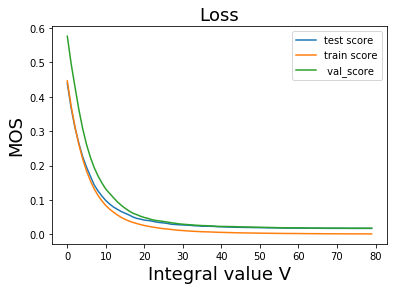

In [123]:
test_score = np.empty(len(final_model.estimators_))
train_score = np.empty(len(final_model.estimators_))
val_score = np.empty(len(final_model.estimators_))

for i, pred in enumerate(final_model.staged_predict (X_test)):
    test_score[i] = final_model.loss_(y_test, pred)

for i, pred in enumerate(final_model.staged_predict(X)):
    train_score[i] = final_model.loss_(y, pred)
    
for i, pred in enumerate(final_model.staged_predict(X_val)):
    val_score[i] = final_model.loss_(y_val, pred)    

plt.plot(test_score)
plt.plot(train_score)
plt.plot( val_score)

plt.title('Loss', fontsize=18)
plt.xlabel("Integral value V", fontsize=18)
plt.ylabel("MOS", fontsize=18)

plt.legend(['test score', 'train score', " val_score"])

## Evaluation
The publication managed to achieve the result of **0.96**. However, here, after a careful search of the hyperparameters, it turned out as much as 0.98

The result changes slightly depending on the partition, initialization of the random variable, etc., but the quality of the model is **0.98**

In [124]:
default_mae, default_corr = fit_and_evaluate(default_model)
final_mae, final_corr = fit_and_evaluate(final_model)

print('default_model Performance: MAE test = %0.4f, MAE val = %0.4f' % default_mae)
print('final_model Performance: MAE test = %0.4f, MAE val = %0.4f' % final_mae)

SRCC test 0.9738 2.771829704289645e-29
SRCC validation 0.9809 3.2916893609309045e-32


/home/ksant/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


SRCC test 0.9805 5.092574057151368e-32
SRCC validation 0.9794 1.5630191181760922e-31
default_model Performance: MAE test = 0.1293, MAE val = 0.1043
final_model Performance: MAE test = 0.0673, MAE val = 0.0731


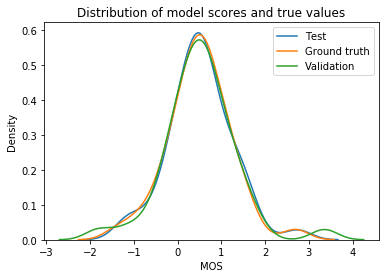

In [126]:
#figsize(8, 8)

# Density plot of the final predictions and the test values
sns.kdeplot(final_pred, label = 'Test')
sns.kdeplot(y_test, label = 'Ground truth')
#sns.kdeplot(final_pred_val, label = 'Validation')
sns.kdeplot(y_val, label = 'Validation')

# Label the plot
plt.xlabel('MOS'); plt.ylabel('Density');
plt.title('Distribution of model scores and true values');

# Comparison of true and simulated values

In [129]:
def vqa (data):
    mos = 100/(1+math.exp(-data))
    return mos
final_pred_v = list (map(lambda x : vqa(x), final_pred))
y_test_v = list (map(lambda x : vqa(x), y_test))
y_val_v= list (map(lambda x : vqa(x), y_val))
final_pred_val_v= list (map(lambda x : vqa(x), final_pred_val))

Text(0.5, 1.0, 'Gradient Boosting model')

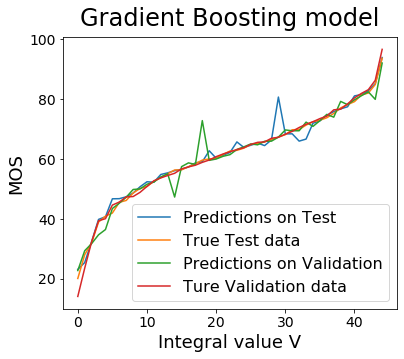

In [130]:
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(1, 1, 1)

#plt.style.use('grayscale')

plt.plot(final_pred_v, label = "Predictions on Test")
plt.plot(y_test_v, label = "True Test data")

plt.plot(final_pred_val_v, label = "Predictions on Validation")
plt.plot(y_val_v, label = "Ture Validation data")
plt.legend(fontsize=16)

ax.set_xlabel("Integral value V", fontsize=18)
ax.set_ylabel("MOS", fontsize=18)

#plt.xlabel('xlabel', fontsize=18)

ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)

ax.set_title("Gradient Boosting model", fontsize=24, verticalalignment='bottom')

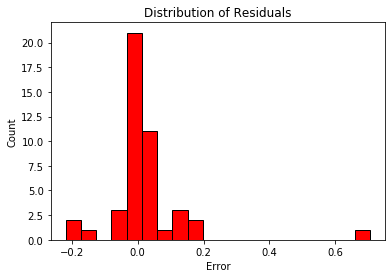

In [131]:
figsize = (6, 6)

# Calculate the residuals 
residuals = final_pred - y_test

# Plot the residuals in a histogram
plt.hist(residuals, color = 'red', bins = 20,
         edgecolor = 'black')
plt.xlabel('Error'); plt.ylabel('Count')
plt.title('Distribution of Residuals');

# Save the model to disk

In [134]:
import pickle
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

## Next
Next, we will build some simplified models and a referense-free model
And also let's analyze how our model works with [LIME](https://github.com/marcotcr/lime)